## 1. Importando bibliotecas

In [131]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xgboost as xgb
import yfinance as yf
import pmdarima as pm
from prophet import Prophet
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
from statsmodels.tsa.seasonal import seasonal_decompose
from mpl_finance import candlestick_ohlc 
import matplotlib.dates as mpl_dates 
import datetime
from datetime import datetime, timedelta

In [10]:
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore")

### Métricas de avaliação

In [12]:
# Funções de Avaliação
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return mae, mse, mape


def print_metrics(metrics):
    mae, mse, mape = metrics
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape:.2f} %")

## 2. Importando dados

In [2]:
brent_data = yf.Ticker("BZ=F")
brent_df = pd.DataFrame(brent_data.history(period="max"))

# Ajustando o index para não mostrar horas
brent_df['Date'] = pd.to_datetime(brent_df.index, format='%Y-%m-%d').date
brent_df.index = brent_df['Date']
brent_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Date
Date,,,,,,,,
2007-07-30,75.849998,76.529999,75.440002,75.739998,2575,0.0,0.0,2007-07-30
2007-07-31,75.699997,77.169998,75.669998,77.050003,3513,0.0,0.0,2007-07-31
2007-08-01,77.000000,77.059998,74.860001,75.349998,3930,0.0,0.0,2007-08-01
2007-08-02,75.220001,76.209999,74.269997,75.760002,6180,0.0,0.0,2007-08-02
2007-08-03,75.389999,76.000000,74.529999,74.750000,4387,0.0,0.0,2007-08-03


In [3]:
brent_df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Date
Date,,,,,,,,
2025-01-09,76.160004,77.269997,75.699997,76.919998,31706,0.0,0.0,2025-01-09
2025-01-10,77.209999,80.760002,77.040001,79.760002,92049,0.0,0.0,2025-01-10
2025-01-13,79.550003,81.669998,79.540001,81.010002,77109,0.0,0.0,2025-01-13
2025-01-14,80.910004,81.139999,79.860001,79.919998,77109,0.0,0.0,2025-01-14
2025-01-15,80.320000,80.629997,79.629997,80.169998,13750,0.0,0.0,2025-01-15


## 3. Análise exploratória

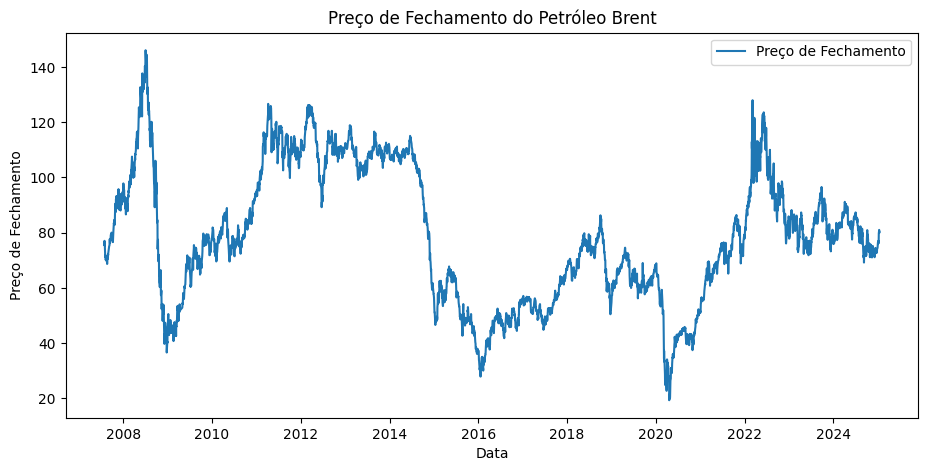

In [16]:
# Visualização dos dados
plt.figure(figsize=(11, 5))
plt.plot(brent_df["Date"], brent_df["Close"], label="Preço de Fechamento")
plt.title("Preço de Fechamento do Petróleo Brent")
plt.xlabel("Data")
plt.ylabel("Preço de Fechamento")
plt.legend()
plt.show()


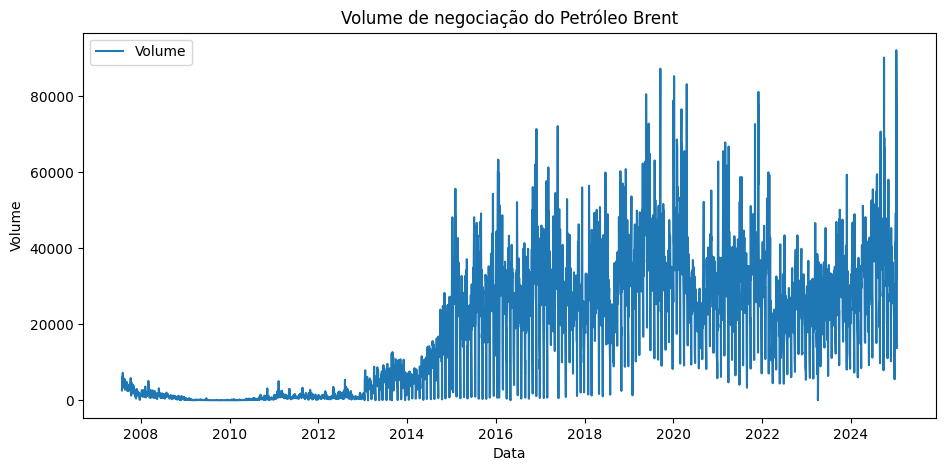

In [23]:
# Visualização dos dados do valume como esboço para o dash
plt.figure(figsize=(11, 5))
plt.plot(brent_df["Date"], brent_df["Volume"], label="Volume")
plt.title("Volume de negociação do Petróleo Brent")
plt.xlabel("Data")
plt.ylabel("Volume")
plt.legend()
plt.show()


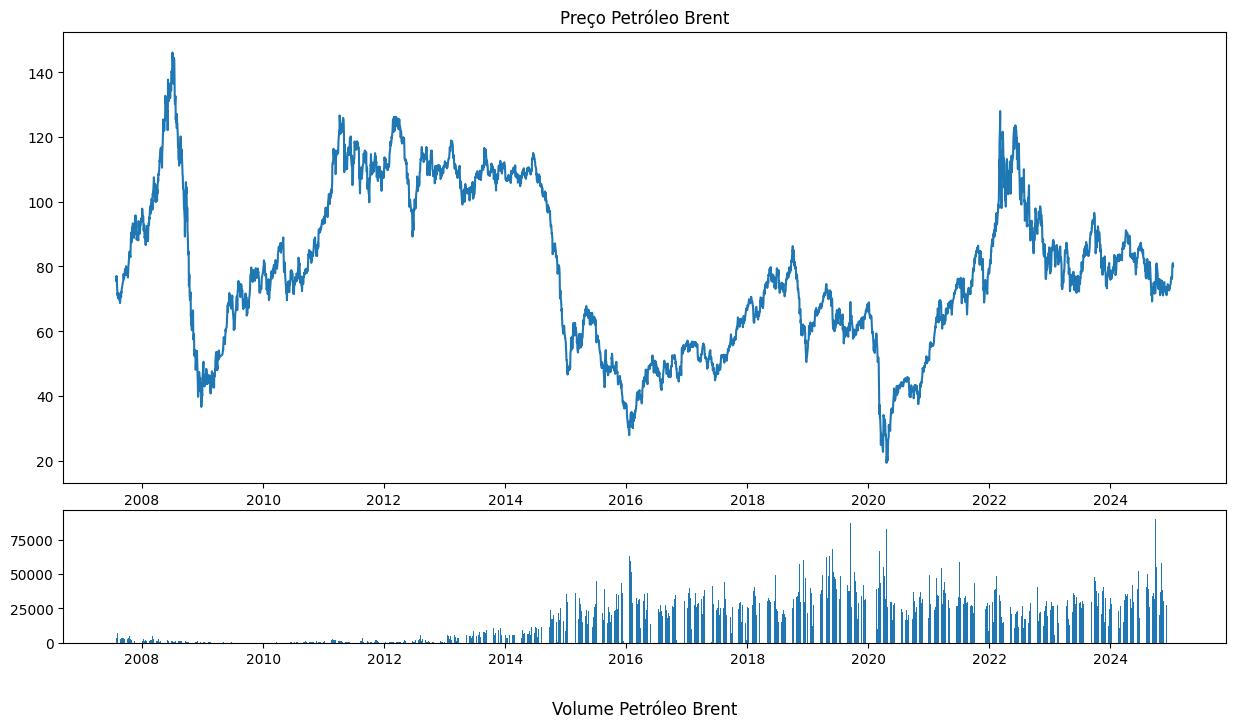

In [22]:
# Plotando preço mais volume como esboço para o dash
top_plt = plt.subplot2grid((5,4), (0, 0), rowspan=3, colspan=4)
top_plt.plot(brent_df['Date'], brent_df["Close"])
plt.title('Preço Petróleo Brent')
bottom_plt = plt.subplot2grid((5,4), (3,0), rowspan=1, colspan=4)
bottom_plt.bar(brent_df['Date'], brent_df['Volume'])
plt.title('\nVolume Petróleo Brent', y=-0.60)
plt.gcf().set_size_inches(15,10)

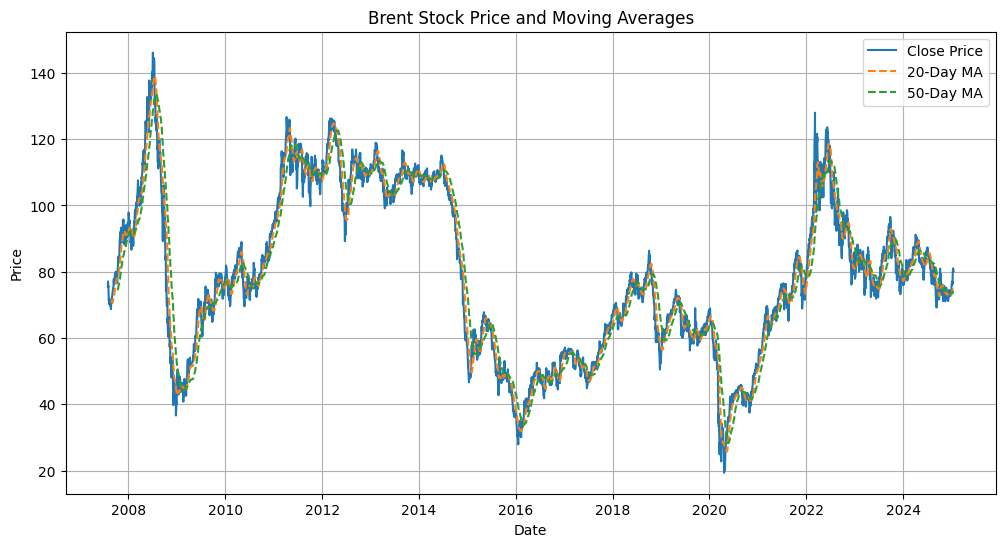

In [32]:
# Calculando Médias Móveis como esboço para o dash
stock_data = brent_df.copy()
stock_data['MA20'] = stock_data['Close'].rolling(window=20).mean()
stock_data['MA50'] = stock_data['Close'].rolling(window=50).mean()

# Plotando
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Close'], label='Close Price')
plt.plot(stock_data['MA20'], label='20-Day MA', linestyle='--')
plt.plot(stock_data['MA50'], label='50-Day MA', linestyle='--')
plt.title('Brent Stock Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

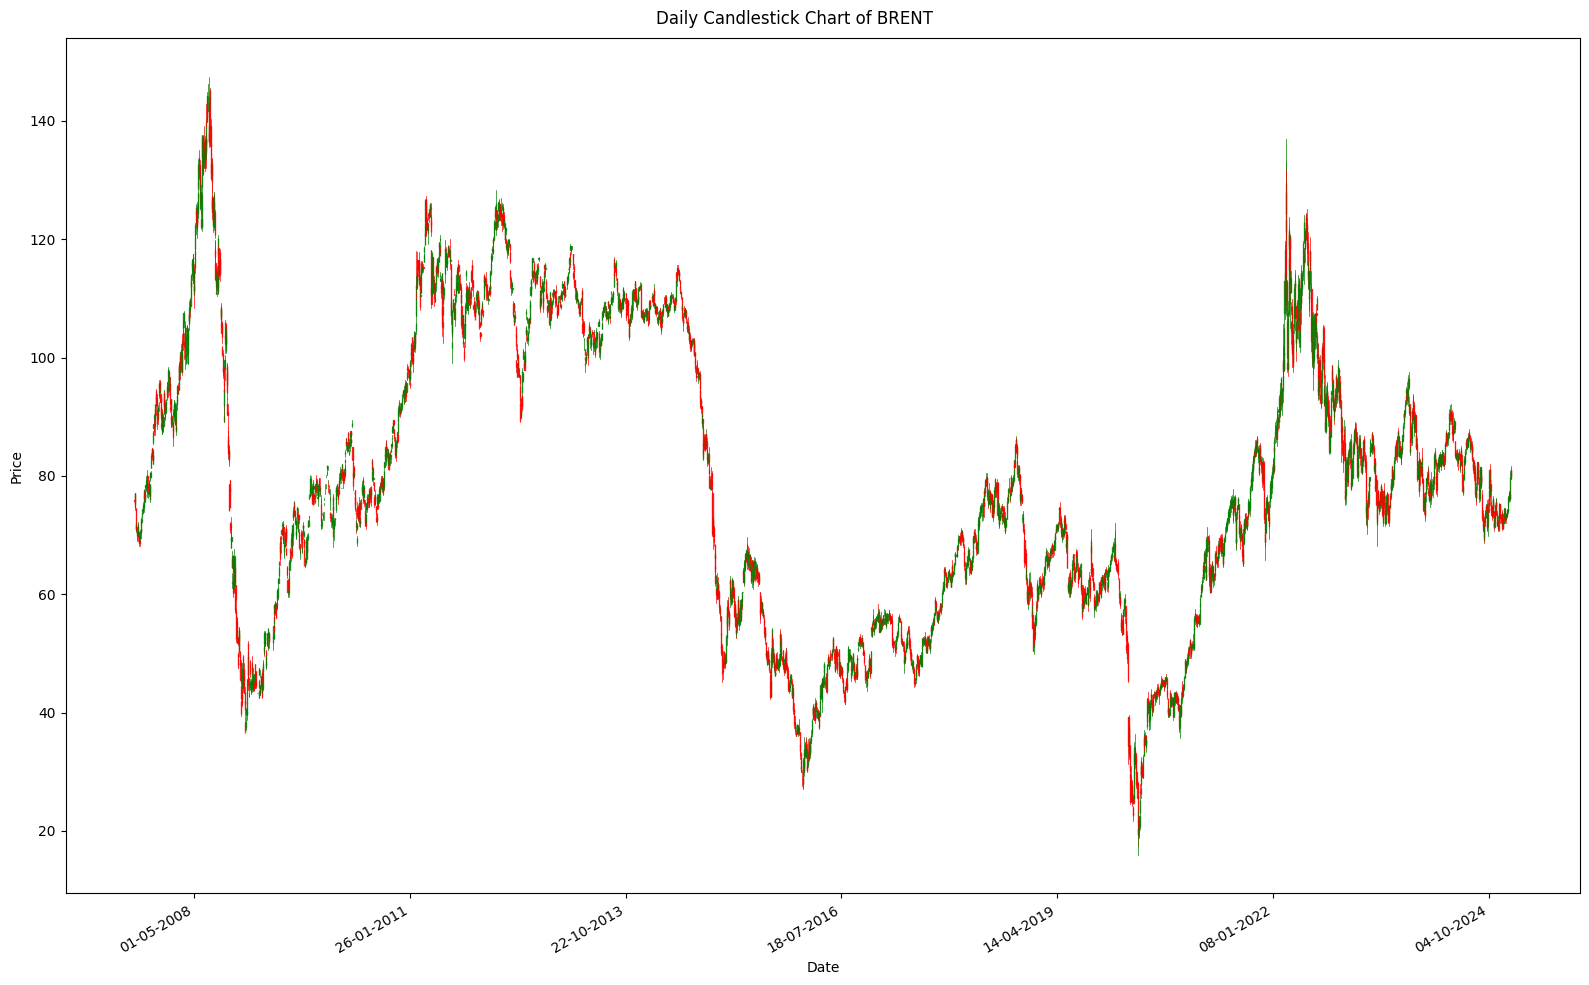

In [189]:
# Criando gráfico de candlestick como esboço para o dash
data = brent_df.copy()
ohlc = data.loc[:, ['Date', 'Open', 'High', 'Low', 'Close']] 
  
# covertendo para formato de data
ohlc['Date'] = pd.to_datetime(ohlc['Date']) 
ohlc['Date'] = ohlc['Date'].apply(mpl_dates.date2num) 
ohlc = ohlc.astype(float) 
  
# criando Subplots 
fig, ax = plt.subplots(figsize=(16, 10)) 
  
candlestick_ohlc(ax, ohlc.values, width=0.6, 
                 colorup='green', colordown='red', alpha=0.8) 
  
# Setting labels & titles 
ax.set_xlabel('Date') 
ax.set_ylabel('Price') 
fig.suptitle('Daily Candlestick Chart of BRENT') 
  
# formatando Date 
date_format = mpl_dates.DateFormatter('%d-%m-%Y') 
ax.xaxis.set_major_formatter(date_format) 
fig.autofmt_xdate() 
  
fig.tight_layout() 
  
plt.show() 

In [7]:
brent_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4343 entries, 2007-07-30 to 2025-01-15
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          4343 non-null   float64
 1   High          4343 non-null   float64
 2   Low           4343 non-null   float64
 3   Close         4343 non-null   float64
 4   Volume        4343 non-null   int64  
 5   Dividends     4343 non-null   float64
 6   Stock Splits  4343 non-null   float64
 7   Date          4343 non-null   object 
dtypes: float64(6), int64(1), object(1)
memory usage: 305.4+ KB


In [8]:
brent_df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,4343.000000,4343.000000,4343.000000,4343.000000,4343.000000,4343.0,4343.0
mean,78.621441,79.597258,77.594642,78.625195,18566.413769,0.0,0.0
std,24.283647,24.394198,24.160514,24.302547,16572.145945,0.0,0.0
min,19.559999,21.270000,16.000000,19.330000,0.000000,0.0,0.0
25%,60.209999,61.065001,59.125000,60.175001,1326.500000,0.0,0.0
50%,76.669998,77.629997,75.650002,76.769997,18879.000000,0.0,0.0
75%,100.205002,101.445000,98.810001,100.265003,31239.000000,0.0,0.0
max,146.080002,147.429993,144.270004,146.080002,92049.000000,0.0,0.0


### Decomposição da Série Temportal

<Axes: xlabel='Date'>

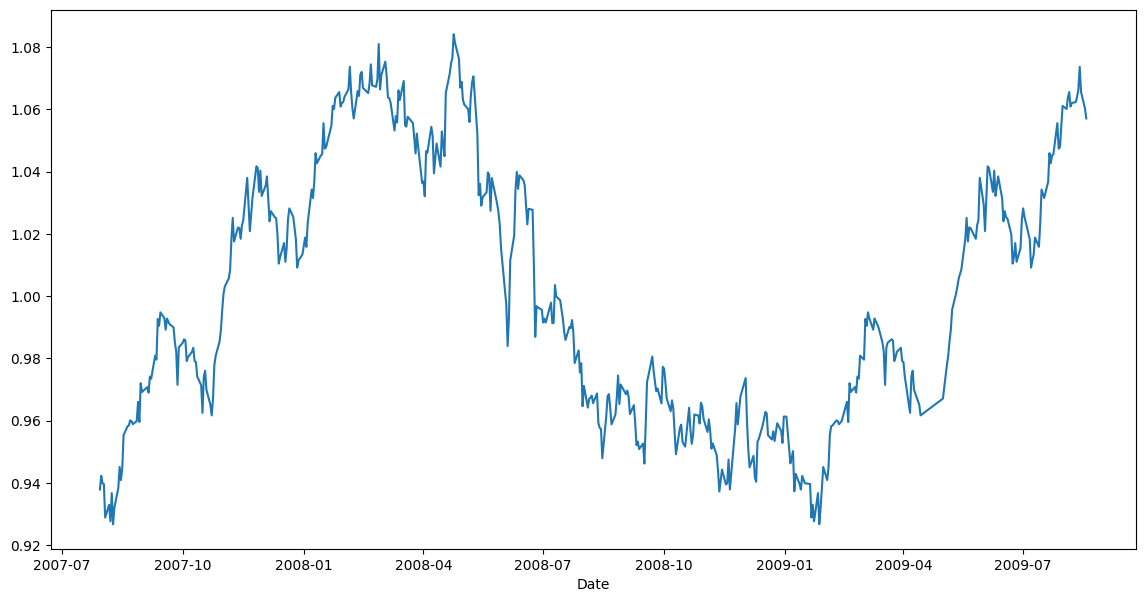

In [13]:
result = seasonal_decompose(brent_df["Close"], model="multiplicative", period=365)
result.seasonal.iloc[:500].plot(figsize=(14, 7))

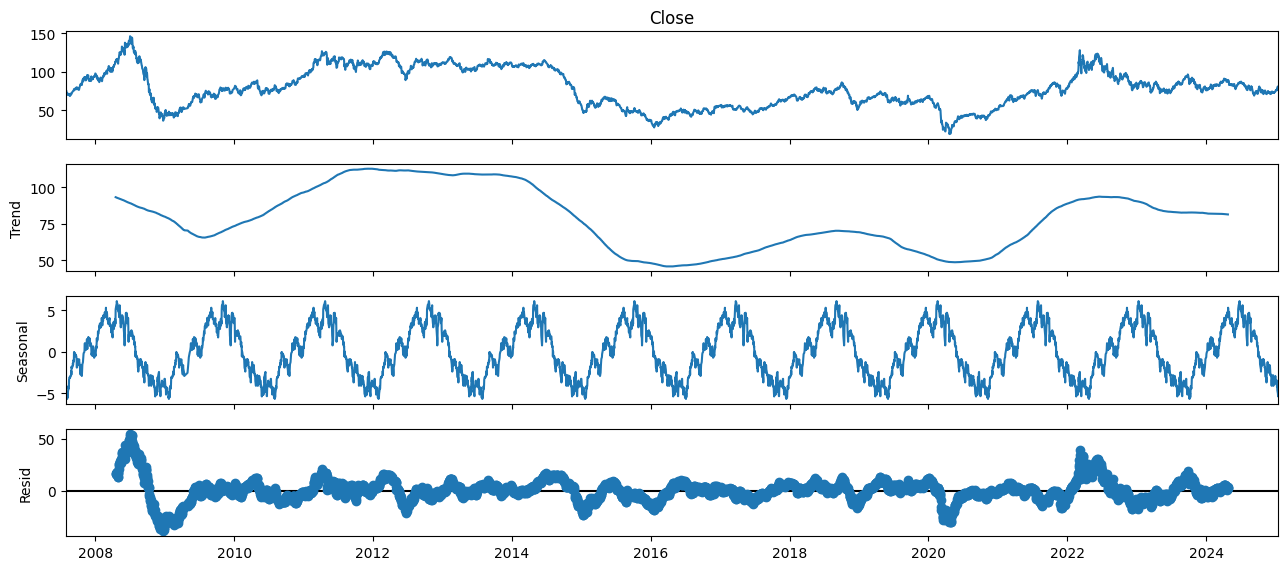

In [14]:
# Decomposição da série temporal
result = seasonal_decompose(brent_df["Close"], model="additive", period=365)
fig = result.plot()
fig.set_size_inches(14, 6)

### Decomposição autoregressiva

##### Auto correlação

In [33]:
# acf
from statsmodels.graphics.tsaplots import plot_acf as _plot_acf

data = brent_df.copy()

def plot_acf(data, lags=365, title="Autocorrelação da Série Temporal"):

    fig, ax = plt.subplots(figsize=(15, 5))
    # Obtendo o valor de ACF e intervalo de confiança
    _plot_acf(data, lags=lags, ax=ax, alpha=0.05)
    ax.set_title(title)
    ax.set_xlabel("Lags")
    ax.set_ylabel("Autocorrelação")
    fig.set_tight_layout(True)

    acf_x = sm.tsa.acf(data, alpha=0.05, nlags=365)
    acf, ci = acf_x[:2]
    intercept_point = np.where(abs(acf) < (ci[:, 1] - acf))
    if intercept_point[0].size > 0:
        print(
            f"O coeficiente do ACF interceptou o limite no leg {intercept_point[0][0]}"
        )
    else:
        print(""O coeficiente do ACF não interceptou o limie")

The ACF coefficients intercept the threshold at lag 227


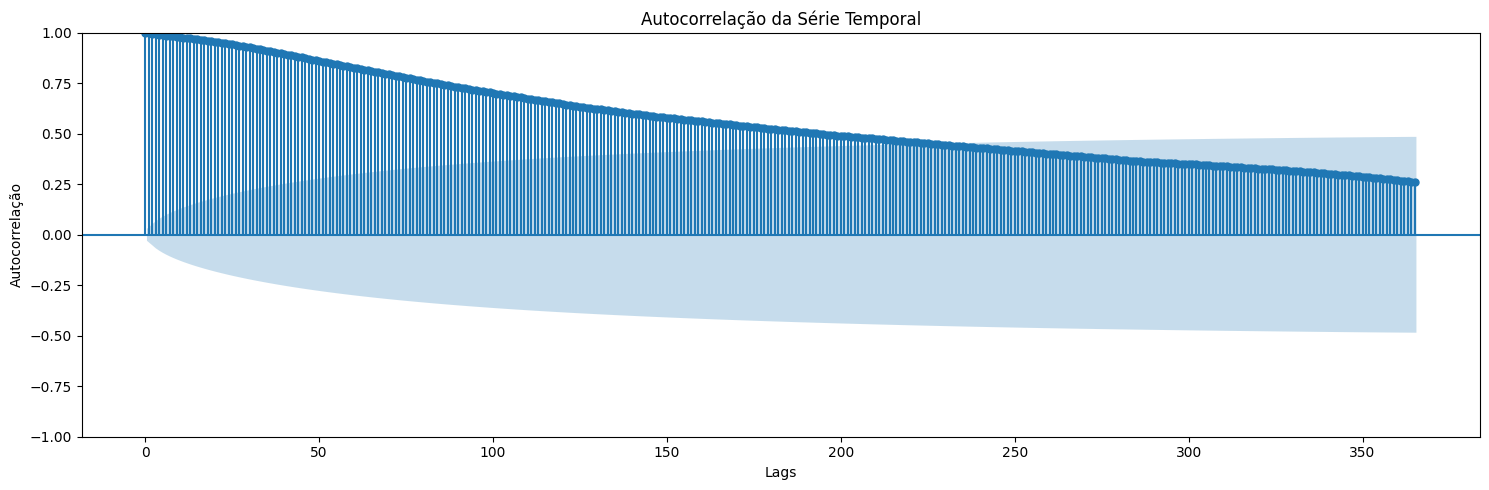

In [34]:
plot_acf(data["Close"])

##### Auto correlação parcial

In [35]:
# acf
from statsmodels.graphics.tsaplots import plot_pacf as _plot_pacf


def plot_pacf(data, lags=30, title="Autocorrelação Parcial da Série Temporal"):

    fig, ax = plt.subplots(figsize=(15, 5))
    # Get the ACF values and confidence intervals
    _plot_pacf(data, lags=lags, ax=ax, alpha=0.05)
    ax.set_title(title)
    ax.set_xlabel("Lags")
    ax.set_ylabel("Autocorrelação Parcial")
    fig.set_tight_layout(True)

    acf_x = sm.tsa.pacf(data, alpha=0.05, nlags=lags)
    acf, ci = acf_x[:2]
    intercept_point = np.where(abs(acf) < (ci[:, 1] - acf))
    if intercept_point[0].size > 0:
        print(
            f"O coeficiente do PACF interceptou o limite no leg {intercept_point[0][0]}"
        )
    else:
        print("O coeficiente do PACF não interceptou o limite")

The PACF coefficients intercept the threshold at lag 2


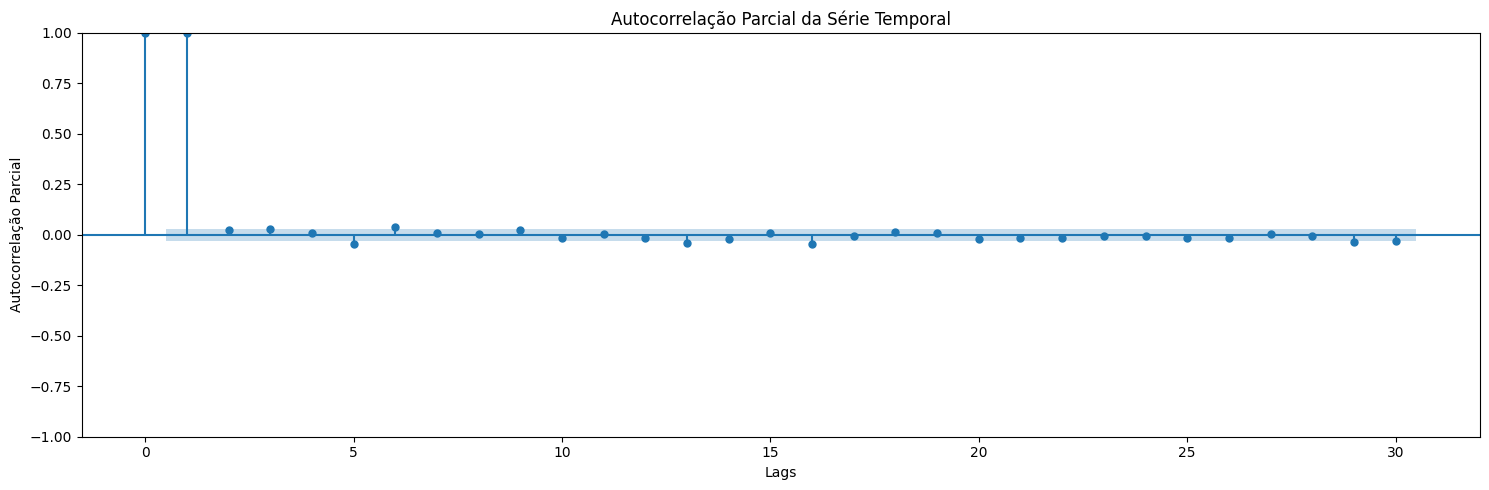

In [36]:
plot_pacf(data["Close"])

#### Diferenciação para estacionariedade

In [37]:
adf_result = sm.tsa.adfuller(data["Close"])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}")

if adf_result[1] < 0.05:
    print("A série temporal é estacionária")
else:
    print("A série temporal não é estacionária")

ADF Statistic: -2.3539507175279395
p-value: 0.1551573230547465
Critical Values: {'1%': -3.4318621755499645, '5%': -2.8622081952035137, '10%': -2.5671256850426554}
A série temporal não é estacionária


<Axes: xlabel='Date'>

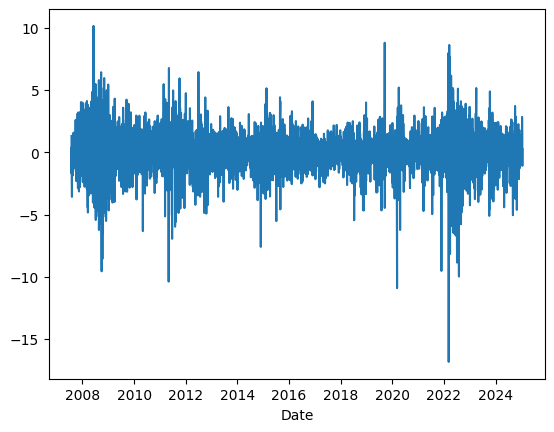

In [38]:
data["Close"].diff().plot()

In [39]:
# diferenciando 1 vez

adf_result = sm.tsa.adfuller(data["Close"].diff().dropna())
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}")

if adf_result[1] < 0.05:
    print("A série temporal é estacionária")
else:
    print("A série temporal não é estacionária")

ADF Statistic: -15.659421452154575
p-value: 1.5606739459611806e-28
Critical Values: {'1%': -3.4318621755499645, '5%': -2.8622081952035137, '10%': -2.5671256850426554}
A série temporal é estacionária


#### Coeficientes de autoregressão

In [41]:
acf_x = sm.tsa.acf(data["Close"], alpha=0.05, nlags=365)
acf, ci = acf_x[:2]
# identificação do q pelo ponto de interceptação ao 95% com o acf
q = np.where(abs(acf) < (ci[:, 1] - acf))[0][0]

pacf_x = sm.tsa.pacf(data["Close"], alpha=0.05, nlags=30)
pacf, ci = pacf_x[:2]
# identificação do p pelo ponto de interceptação ao 95% com o pacf
p = np.where(abs(pacf) < (ci[:, 1] - pacf))[0][0]

d = 1  # apenas 1 diferenciação foi necessária para tornar a série estacionária

In [42]:
# parâmetros do modelo ARIMA
p, q, d

(2, 227, 1)

## 3. Preparação dos Dados e Modelagem

### Dividindo os Dados em Treino e Teste

In [104]:
# Dividindo em treino e teste

train_size = data.shape[0] - 7
train, test = data[:train_size], data[train_size:]


# Preparação dos dados para XGBoost
def create_features(df):
    df["Date"] = pd.to_datetime(df["Date"])
    df["year"] = df["Date"].dt.year
    df["month"] = df["Date"].dt.month
    df["day"] = df["Date"].dt.day
    df["dayofweek"] = df["Date"].dt.dayofweek
    return df


train = create_features(train)
test = create_features(test)

FEATURES = ["year", "month", "day", "dayofweek"]
TARGET = "Close"

### Modelo XGBoost

In [105]:
# Modelo XGBoost
X_train, y_train = train[FEATURES], train[TARGET]
X_test, y_test = test[FEATURES], test[TARGET]

reg = xgb.XGBRegressor(objective="reg:squarederror")
reg.fit(X_train, y_train)

# Avaliação XGBoost
preds = reg.predict(X_test)
metrics_xgb = calculate_metrics(y_test, preds)
print("XGBoost Metrics:")
print_metrics(metrics_xgb)

XGBoost Metrics:
MAE: 1.9929569789341517
MSE: 5.618906641994337
MAPE: 2.50 %


### Modelo Prophet

In [112]:
# Modelo Prophet
train_prophet = train.rename(columns={"Date": "ds", "Close": "y"})
test_prophet = test.rename(columns={"Date": "ds", "Close": "y"})

model = Prophet(daily_seasonality=True)
model.fit(train_prophet)

future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)

preds = forecast[["ds", "yhat"]].tail(len(test))
preds = preds.set_index("ds")
y_test = test_prophet.set_index("ds")["y"]

metrics_pr = calculate_metrics(y_test, preds["yhat"])
print("Prophet Metrics:")
print_metrics(metrics_pr)

17:19:56 - cmdstanpy - INFO - Chain [1] start processing
17:19:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet Metrics:
MAE: 13.101266756731592
MSE: 338.2628490703975
MAPE: 13.64 %


### Modelo SARIMAX

In [113]:
# Modelo SARIMAX

model = sm.tsa.statespace.SARIMAX(
    train["Close"],
    order=(
        p,
        d,
        1,
    ),  # q muito grande faz com que o modelo fique muito complexo e lento
    seasonal_order=(0, 0, 0, 12),
)
results = model.fit()

preds = results.get_forecast(steps=len(test)).predicted_mean

metrics_sarimax = calculate_metrics(test["Close"], preds)
print("SARIMAX Metrics:")
print_metrics(metrics_sarimax)

SARIMAX Metrics:
MAE: 26.52017763012642
MSE: 816.5968904884917
MAPE: 32.62 %


In [109]:
df = pd.DataFrame(
    [metrics_xgb, metrics_pr, metrics_sarimax],
    columns=["MAE", "MSE", "MAPE"],
    index=["XGBoost", "Prophet", "SARIMAX"],
)
df.sort_values(by="MAPE", ascending=True)

,MAE,MSE,MAPE
Prophet,1.939468,4.222158,2.466974
XGBoost,1.992957,5.618907,2.497150
SARIMAX,2.461107,9.081285,3.077825


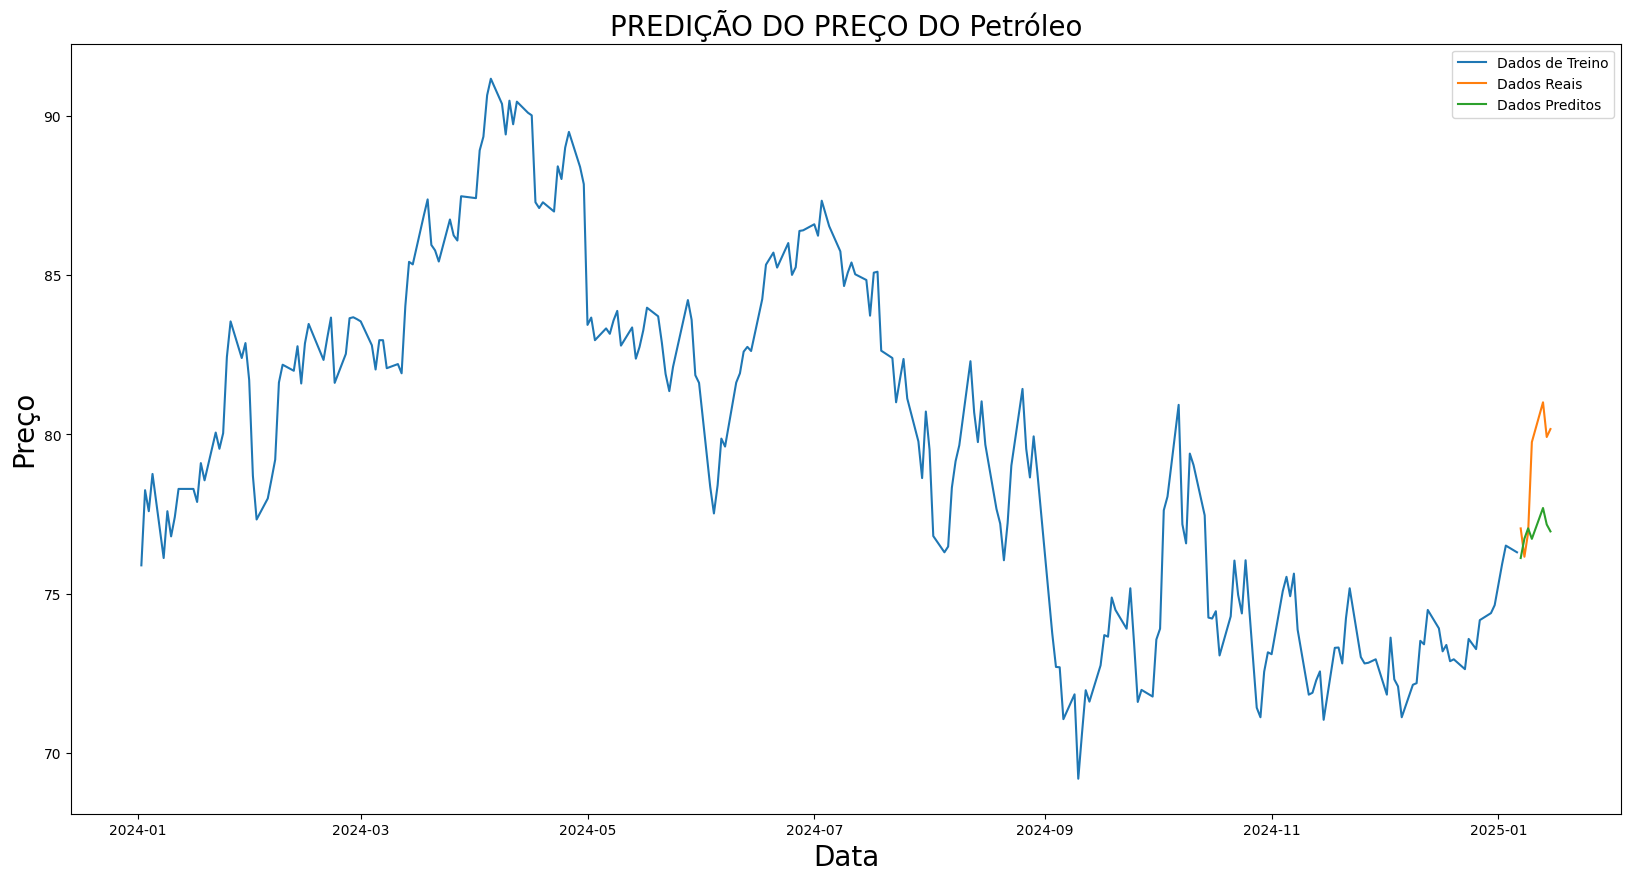

In [110]:
train = train.query('year >= 2024')
test['Predictions'] = reg.predict(X_test)
fig = plt.figure(figsize=(20, 10))
plt.plot(train.index, train['Close'])
plt.plot(test.index, test['Close'])
plt.plot(test.index, test['Predictions'])
plt.xlabel('Data',size=20)
plt.ylabel('Preço',size=20)
plt.title('PREDIÇÃO DO PREÇO DO PETRÓLEO',size=20)
plt.legend(['Dados de Treino','Dados Reais','Dados Preditos'])

#### Backtest

In [111]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
metrics_df = pd.DataFrame()

for train_index, test_index in tscv.split(data):
    train, test = data.iloc[train_index], data.iloc[test_index]

    train = create_features(train)
    test = create_features(test)
    
    X_train, y_train = train[FEATURES], train[TARGET]
    X_test, y_test = test[FEATURES], test[TARGET]
    
    # Fit the model
    reg = xgb.XGBRegressor(objective="reg:squarederror")
    reg.fit(X_train, y_train)
    
    preds = reg.predict(X_test)
    
    
    # metricas
    metrics = calculate_metrics(y_test, preds)
    metrics = pd.DataFrame([metrics], columns=["MAE", "MSE", "MAPE"])
    metrics_df = pd.concat([metrics_df, metrics])
    
# Print average error
print(metrics_df)
print('\nMédas')
print(metrics_df.mean())

         MAE          MSE       MAPE
0  29.547188  1006.775856  26.833690
0  35.300125  2018.169661  72.006815
0  16.487438   413.968398  24.979988
0  16.348802   459.963609  36.320527
0  22.459371   641.264380  27.618079

Médas
MAE      24.028585
MSE     908.028381
MAPE     37.551820
dtype: float64


#### Classe para ser usada no Dash

In [180]:
class Forecast():
    def __init__(self, ticker):
        data = yf.Ticker("BZ=F")
        df = pd.DataFrame(brent_data.history(period="max"))
        
        # Ajustando o index para não mostrar horas
        df['Date'] = pd.to_datetime(df.index, format='%Y-%m-%d').date
        df.index = df['Date']

        self.df = df

    def create_features(self, df):
        df["Date"] = pd.to_datetime(df["Date"])
        df["year"] = df["Date"].dt.year
        df["month"] = df["Date"].dt.month
        df["day"] = df["Date"].dt.day
        df["dayofweek"] = df["Date"].dt.dayofweek
        return df

    def split_train_test(self):
        train_size = self.df.shape[0] - 7
        train, test = self.df[:train_size], self.df[train_size:]
        
        
        # Preparação dos dados para XGBoost
        
        self.train = self.create_features(train)
        self.test = self.create_features(test)
        
        self.FEATURES = ["year", "month", "day", "dayofweek"]
        self.TARGET = "Close"

    def calculate_metrics(self, y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        mape = mean_absolute_percentage_error(y_true, y_pred) * 100
        return mae, mse, mape

    def train_xgb(self):
        # Modelo XGBoost
        X_train, y_train = self.train[self.FEATURES], self.train[self.TARGET]
        X_test, y_test = self.test[self.FEATURES], self.test[self.TARGET]
        
        reg = xgb.XGBRegressor(objective="reg:squarederror")
        reg.fit(X_train, y_train)
        
        # Avaliação XGBoost
        preds = reg.predict(X_test)
        metrics = self.calculate_metrics(y_test, preds)
        self.metrics_xgb = pd.DataFrame([metrics], columns=["MAE", "MSE", "MAPE"])
        self.xgb_model = reg
        self.xbg_train_df = self.train
        self.xgb_test_df = self.test.copy()
        self.xgb_test_df['Predictions'] = reg.predict(X_test)

    def predict_future_days(self):
        days = []
        for i in range(6):
            day = (datetime.today() + timedelta(days=i)).strftime('%Y-%m-%d')
        
            days.append(day)
        df = pd.DataFrame(days, columns=['Date'])
        
        X_pred = self.create_features(df)
        X_pred = X_pred.set_index('Date')
        preds = reg.predict(X_pred)

        self.df_real = pd.concat([self.xbg_train_df, self.xgb_test_df])
        X_pred['Close'] = preds
        self.seven_days_pred = X_pred
        

        

##### Testando a classe

In [181]:
brent = Forecast('BZ=F')
brent.split_train_test()

In [182]:
brent.train_xgb()

In [183]:
brent.metrics_xgb

,MAE,MSE,MAPE
0,2.3201,8.470913,2.877975


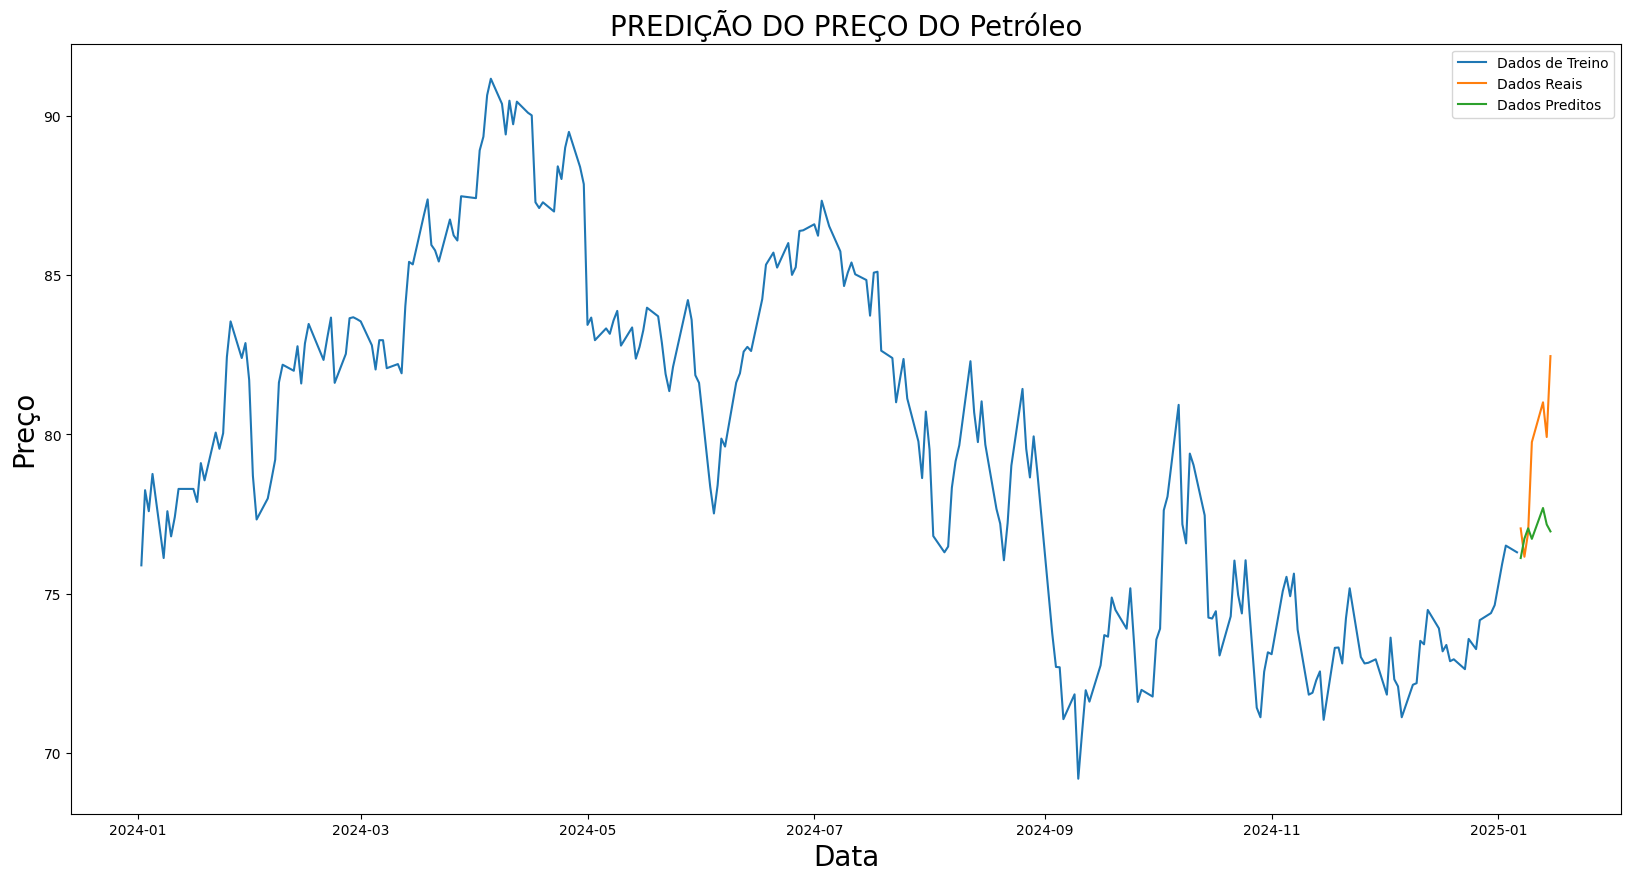

In [184]:
brent.xbg_train_df = brent.xbg_train_df.query('year >= 2024')

fig = plt.figure(figsize=(20, 10))
plt.plot(brent.xbg_train_df.index, brent.xbg_train_df['Close'])
plt.plot(brent.xgb_test_df.index, brent.xgb_test_df['Close'])
plt.plot(brent.xgb_test_df.index, brent.xgb_test_df['Predictions'])
plt.xlabel('Data',size=20)
plt.ylabel('Preço',size=20)
plt.title('PREDIÇÃO DO PREÇO DO PETRÓLEO',size=20)
plt.legend(['Dados de Treino','Dados Reais','Dados Preditos'])

In [185]:
brent.predict_future_days()

In [186]:
brent.seven_days_pred

,year,month,day,dayofweek,Close
Date,,,,,
2025-01-15,2025,1,15,2,86.405830
2025-01-16,2025,1,16,3,86.714622
2025-01-17,2025,1,17,4,86.209198
2025-01-18,2025,1,18,5,85.997192
2025-01-19,2025,1,19,6,87.136375
2025-01-20,2025,1,20,0,86.682686


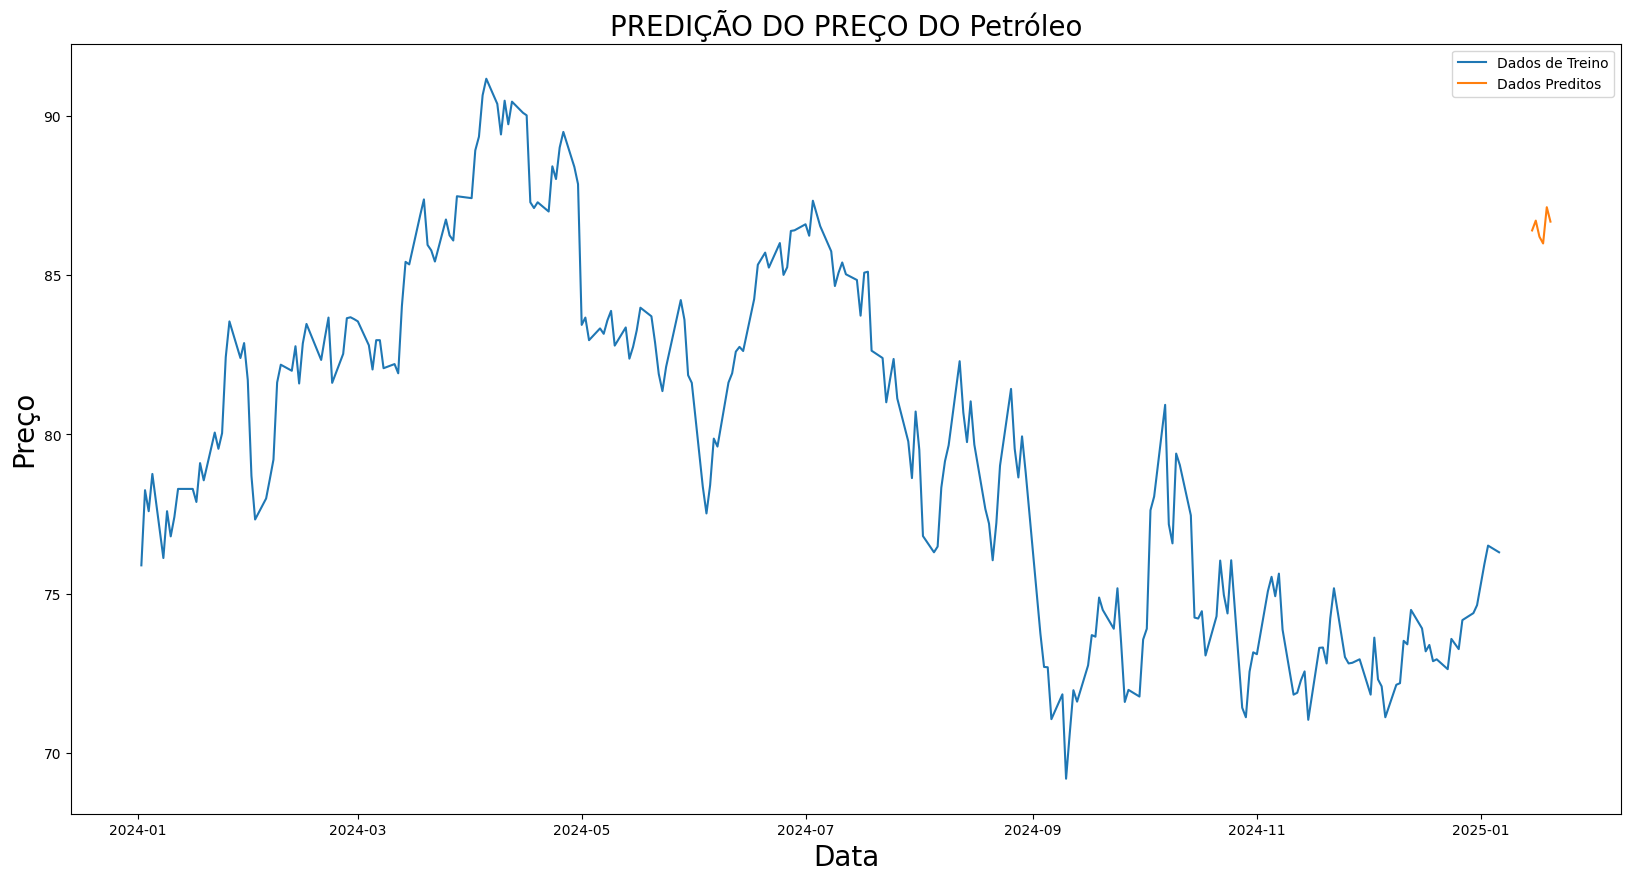

In [188]:
brent.df_real = brent.df_real.query('year >= 2024')

fig = plt.figure(figsize=(20, 10))
plt.plot(brent.xbg_train_df.index, brent.xbg_train_df['Close'])
plt.plot(brent.seven_days_pred.index, brent.seven_days_pred['Close'])
plt.xlabel('Data',size=20)
plt.ylabel('Preço',size=20)
plt.title('PREDIÇÃO DO PREÇO DO PETRÓLEO',size=20)
plt.legend(['Dados de Treino','Dados Preditos'])